# Early Model Testing

In [1]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import seaborn as sns
import os
import time
from sklearn.ensemble import RandomForestRegressor

### Load dataset

In [2]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(140350, 445)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [3]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.9 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

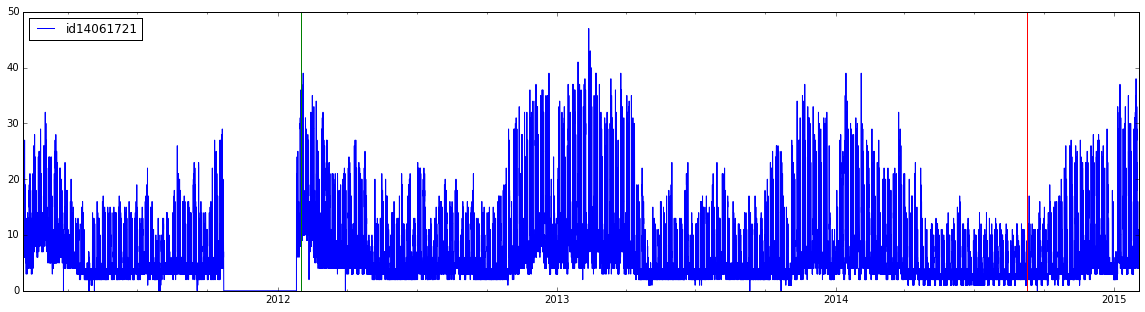

In [4]:
f = original_data[["id14061721"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

## Feature Importances

Mean importances of all sensors

In [5]:
wetaher_current_cols =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_cols =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_cols =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

feature_importances = pd.DataFrame(columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'horizon']))
feature_importances.index.name = "Feature"

In [6]:
sensors_list = list(data)[:30] # Sensor ids (30)

for sensor_name in sensors_list:
    print "Working with sensor: {}".format(sensor_name)
    
    # Create dataframe for specific sensor
    sensor_cols_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
    sensor_data_cols = [col for col in list(data) if col not in sensor_cols_to_drop]
    sensor_data = data[sensor_data_cols]
    
    # Replace 'sensor id' column names with 'measurement'
    sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)
    
    # Prepare columns to shift
    columnsToShift = list(sensor_data)
    shiftedColumns = ["shifted_" + col for col in columnsToShift]
    
    # Prepare datasets
    measurements_cols = [col for col in list(sensor_data) if col.startswith('measurement')]    
    all_cols = measurements_cols + wetaher_current_cols + weather_forecasted_cols + date_time_cols 

    for horizon in range (1,25):
        print "Horizon: {}h".format(horizon)
        
        sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(horizon, freq='H')
        sensor_data.dropna(inplace=True)

        training_data = sensor_data[:splitting_time]
        testing_data = sensor_data[splitting_time:]

        model = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=8)

        X_train = training_data[all_cols].values
        y_train = training_data[["shifted_measurement"]].values.ravel()

        X_test = testing_data[all_cols].values
        y_test = testing_data[["shifted_measurement"]].values.ravel()

        start = time.time() # Start measuring time
        model.fit(X_train,y_train)
        runtime = time.time() - start # Calculate runtime

        feature_importances.loc[:,(sensor_name, horizon)] = model.feature_importances_

feature_importances.index = all_cols # Replaces index names
#feature_importances

Working with sensor: id14061671
Horizon: 1h

C:\Python27\lib\site-packages\pandas\core\frame.py:2524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
C:\Python27\lib\site-packages\pandas\core\frame.py:2148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]



Horizon: 2h
Horizon: 3h
Horizon: 4h
Horizon: 5h
Horizon: 6h
Horizon: 7h
Horizon: 8h
Horizon: 9h
Horizon: 10h
Horizon: 11h
Horizon: 12h
Horizon: 13h
Horizon: 14h
Horizon: 15h
Horizon: 16h
Horizon: 17h
Horizon: 18h
Horizon: 19h
Horizon: 20h
Horizon: 21h
Horizon: 22h
Horizon: 23h
Horizon: 24h
Working with sensor: id14061684
Horizon: 1h
Horizon: 2h
Horizon: 3h
Horizon: 4h
Horizon: 5h
Horizon: 6h
Horizon: 7h
Horizon: 8h
Horizon: 9h
Horizon: 10h
Horizon: 11h
Horizon: 12h
Horizon: 13h
Horizon: 14h
Horizon: 15h
Horizon: 16h
Horizon: 17h
Horizon: 18h
Horizon: 19h
Horizon: 20h
Horizon: 21h
Horizon: 22h
Horizon: 23h
Horizon: 24h
Working with sensor: id14061709
Horizon: 1h
Horizon: 2h
Horizon: 3h
Horizon: 4h
Horizon: 5h
Horizon: 6h
Horizon: 7h
Horizon: 8h
Horizon: 9h
Horizon: 10h
Horizon: 11h
Horizon: 12h
Horizon: 13h
Horizon: 14h
Horizon: 15h
Horizon: 16h
Horizon: 17h
Horizon: 18h
Horizon: 19h
Horizon: 20h
Horizon: 21h
Horizon: 22h
Horizon: 23h
Horizon: 24h
Working with sensor: id14061716
Horizo

C:\Python27\lib\site-packages\IPython\kernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
output_file_name = "featureImportanceResultsAll.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

feature_importances.to_csv(output_file_path)

Compute means of all sensors

In [8]:
feature_importances_all = feature_importances.groupby(level='horizon',axis=1).mean()
feature_importances_all

horizon,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
measurement,0.029041,0.004482,0.003449,0.005173,0.002368,0.004466,0.014252,0.007913,0.003887,0.006058,...,0.003412,0.003134,0.002078,0.002470,0.003604,0.006164,0.002630,0.023338,0.129730,0.253319
measurement_roll_mean_1h,0.900516,0.052367,0.012554,0.029262,0.028093,0.013193,0.005589,0.017825,0.010034,0.008582,...,0.003154,0.028489,0.004920,0.003284,0.003402,0.004972,0.005689,0.004618,0.010492,0.103747
measurement_roll_mean_6h,0.019046,0.800308,0.868715,0.819428,0.678031,0.458100,0.100666,0.022622,0.023485,0.018690,...,0.027854,0.023074,0.041925,0.021002,0.018860,0.018232,0.016629,0.016845,0.011936,0.008533
measurement_roll_mean_d,0.000975,0.002660,0.003229,0.002386,0.005464,0.057747,0.314661,0.376637,0.383981,0.407745,...,0.405553,0.414987,0.407695,0.399035,0.385935,0.378441,0.323396,0.269790,0.181314,0.116452
measurement_roll_mean_w,0.001047,0.001928,0.001626,0.001541,0.002123,0.003578,0.003896,0.003926,0.003932,0.004034,...,0.003633,0.003849,0.004362,0.004810,0.006006,0.006581,0.007393,0.008289,0.014712,0.022371
measurement_roll_mean_m,0.000911,0.001620,0.001728,0.001695,0.001900,0.002452,0.003311,0.003700,0.003637,0.003587,...,0.003448,0.003416,0.003489,0.003533,0.003858,0.004797,0.004995,0.005027,0.008781,0.019643
measurement_roll_min2_d,0.000239,0.001450,0.001199,0.000952,0.002623,0.009161,0.013376,0.013844,0.014169,0.012773,...,0.013127,0.014760,0.015444,0.015130,0.014809,0.014276,0.014560,0.014960,0.015599,0.010327
measurement_roll_min2_w,0.000116,0.000323,0.000306,0.000225,0.000248,0.000452,0.000524,0.000599,0.000654,0.000607,...,0.000518,0.000552,0.000566,0.000637,0.000611,0.000617,0.000830,0.000863,0.000907,0.000721
measurement_roll_max2_d,0.000727,0.002133,0.002119,0.001902,0.004126,0.008670,0.009682,0.011736,0.011353,0.009262,...,0.010029,0.010525,0.009633,0.009348,0.010819,0.010166,0.023442,0.033277,0.045871,0.074451
measurement_roll_max2_w,0.000297,0.000552,0.000565,0.000485,0.000511,0.000747,0.000987,0.001002,0.000977,0.000963,...,0.000913,0.000941,0.001150,0.001126,0.001272,0.001276,0.001354,0.001606,0.001945,0.001562


In [9]:
output_file_name = "featureImportanceResults.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

feature_importances_all.to_csv(output_file_path)

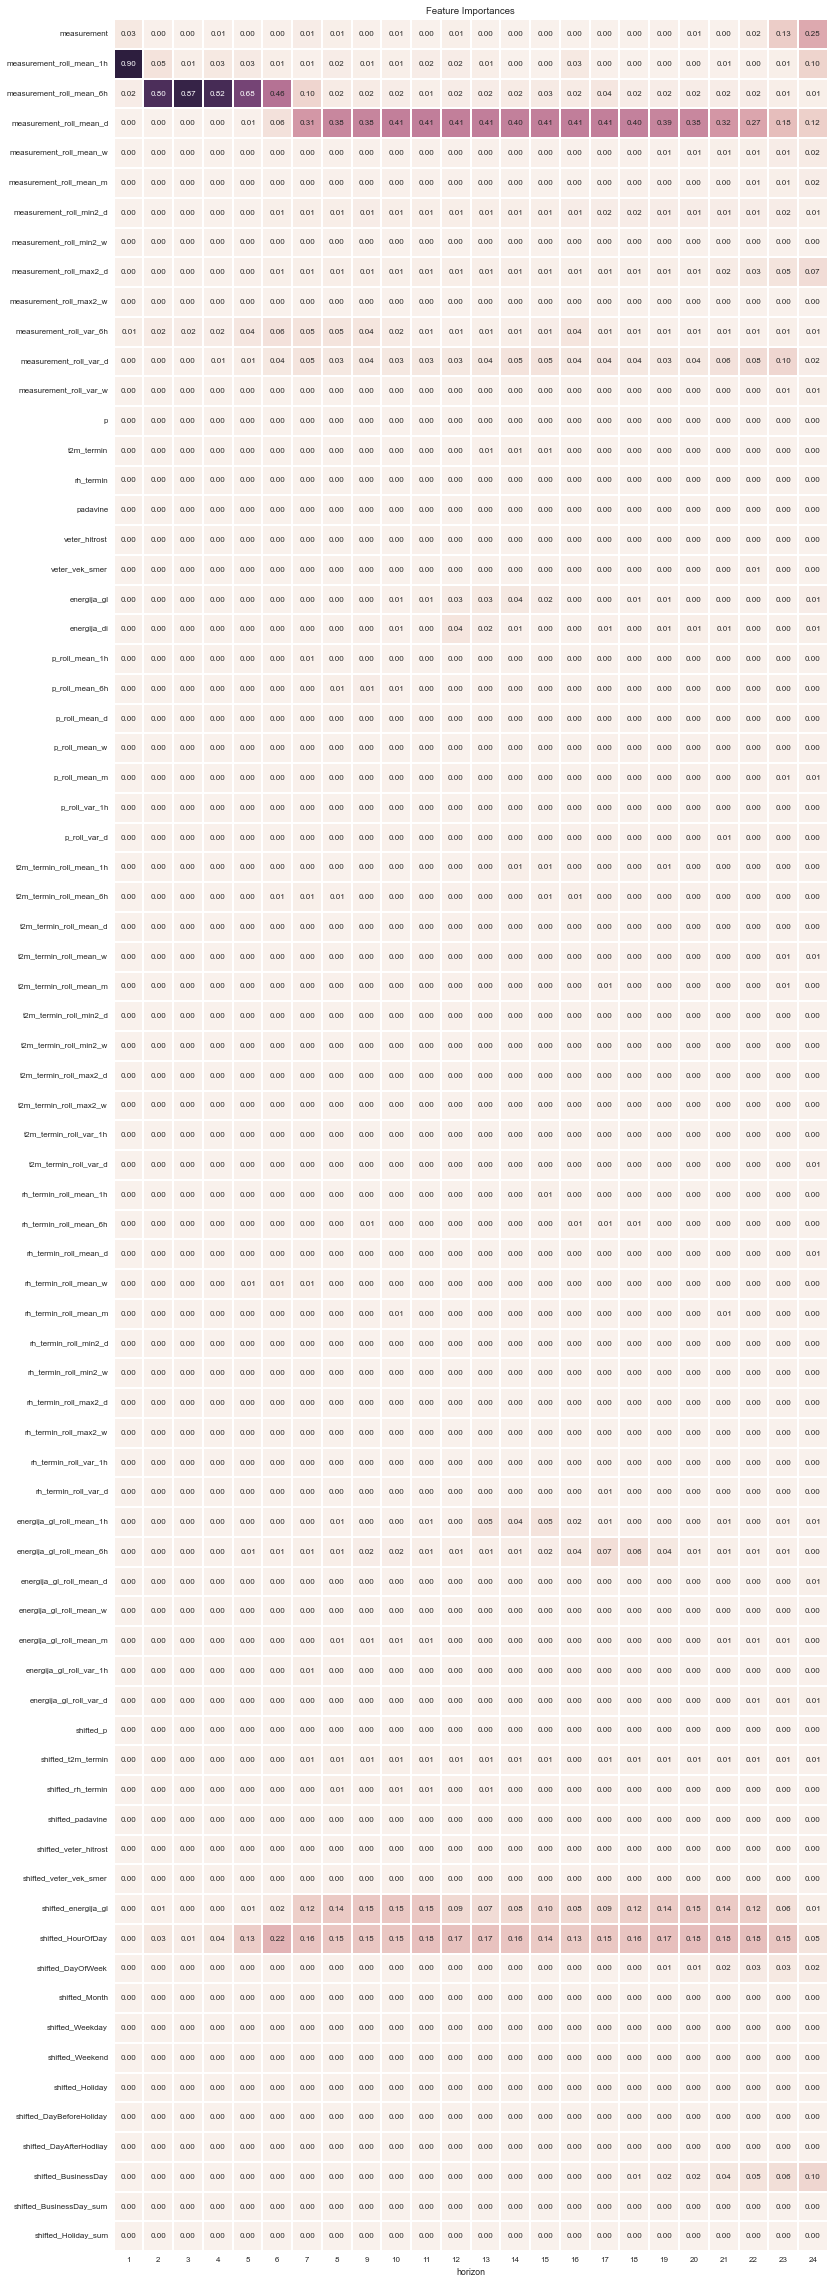

In [49]:
#import seaborn as sns
sns.set(context="paper", font="monospace")
sns.set_style("white")

f, ax = plt.subplots(figsize=(30, 40))
sns.heatmap(feature_importances_all, square=True, annot=True, annot_kws={"size": 8}, fmt=".2f", cbar=False)
plt.title("Feature Importances")
plt.savefig("./figures/featureImportanceAll.pdf")
plt.savefig("./figures/featureImportanceAll.png", dpi=300)

## Top 20 Features of All Time

In [12]:
feature_importances_all_mean = feature_importances_all.mean(axis=1)
feature_importances_all_mean.sort(ascending=False, inplace=True)
feature_importances_all_mean[:20]

measurement_roll_mean_d     0.269856
measurement_roll_mean_6h    0.170042
shifted_HourOfDay           0.134645
shifted_energija_gl         0.084231
measurement_roll_mean_1h    0.054039
measurement_roll_var_d      0.036043
measurement                 0.021989
measurement_roll_var_6h     0.020020
energija_gl_roll_mean_6h    0.016592
measurement_roll_max2_d     0.014506
shifted_BusinessDay         0.013746
measurement_roll_min2_d     0.010975
energija_gl_roll_mean_1h    0.010022
energija_gl                 0.007798
shifted_DayOfWeek           0.006260
energija_di                 0.006244
shifted_t2m_termin          0.005209
measurement_roll_mean_w     0.005202
t2m_termin_roll_mean_6h     0.004301
measurement_roll_mean_m     0.004155
dtype: float64

Replace index names

In [179]:
top20_indices = np.argsort(list(feature_importances_all.mean(axis=1)))[::-1][0:20]
top20 = feature_importances_all.ix[top20_indices]
new_index_names = ["measurement_MA_d", "measurement_MA_6h", "hour_of_day", "forecasted_global_radiation", 
                   "measurement_MA_h", "measurement_VAR_d", "measurement", "measurement_VAR_6h", "global_radiation_MA_6h", 
                   "measurement_MAX_d", "business_day", "measurement_MIN_d", "gl_radiation_MA_h", "global_radiation", 
                   "day_of_week", "diffusive_radiation", "forecasted_temperature", "measurement_MA_w", "temperature_MA_6h", 
                   "measurement_MA_m"]
top20.index=new_index_names
top20

horizon,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
measurement_MA_d,0.000975,0.002660,0.003229,0.002386,0.005464,0.057747,0.314661,0.376637,0.383981,0.407745,...,0.405553,0.414987,0.407695,0.399035,0.385935,0.378441,0.323396,0.269790,0.181314,0.116452
measurement_MA_6h,0.019046,0.800308,0.868715,0.819428,0.678031,0.458100,0.100666,0.022622,0.023485,0.018690,...,0.027854,0.023074,0.041925,0.021002,0.018860,0.018232,0.016629,0.016845,0.011936,0.008533
hour_of_day,0.003673,0.028342,0.014173,0.037809,0.129355,0.220668,0.161650,0.150573,0.152996,0.154678,...,0.137860,0.134735,0.149962,0.158606,0.172458,0.184012,0.184991,0.180814,0.152201,0.047385
forecasted_global_radiation,0.000885,0.005356,0.003700,0.004833,0.008544,0.021109,0.120374,0.144126,0.147916,0.149607,...,0.100290,0.084621,0.088056,0.124050,0.136399,0.145631,0.141481,0.124742,0.062505,0.010254
measurement_MA_h,0.900516,0.052367,0.012554,0.029262,0.028093,0.013193,0.005589,0.017825,0.010034,0.008582,...,0.003154,0.028489,0.004920,0.003284,0.003402,0.004972,0.005689,0.004618,0.010492,0.103747
measurement_VAR_d,0.001097,0.004372,0.002925,0.006788,0.013822,0.035892,0.046335,0.034123,0.036566,0.033645,...,0.054223,0.037582,0.040126,0.038693,0.033964,0.036137,0.058434,0.076431,0.098156,0.018494
measurement,0.029041,0.004482,0.003449,0.005173,0.002368,0.004466,0.014252,0.007913,0.003887,0.006058,...,0.003412,0.003134,0.002078,0.002470,0.003604,0.006164,0.002630,0.023338,0.129730,0.253319
measurement_VAR_6h,0.009028,0.021265,0.016233,0.017778,0.040478,0.058759,0.050823,0.048764,0.042784,0.022567,...,0.014436,0.043784,0.013234,0.008389,0.006492,0.005963,0.006569,0.006663,0.007290,0.005947
global_radiation_MA_6h,0.001526,0.004296,0.004080,0.003201,0.005915,0.006847,0.009864,0.013641,0.017537,0.019004,...,0.015811,0.038367,0.072752,0.063136,0.037752,0.010344,0.007095,0.006813,0.006829,0.003929
measurement_MAX_d,0.000727,0.002133,0.002119,0.001902,0.004126,0.008670,0.009682,0.011736,0.011353,0.009262,...,0.010029,0.010525,0.009633,0.009348,0.010819,0.010166,0.023442,0.033277,0.045871,0.074451


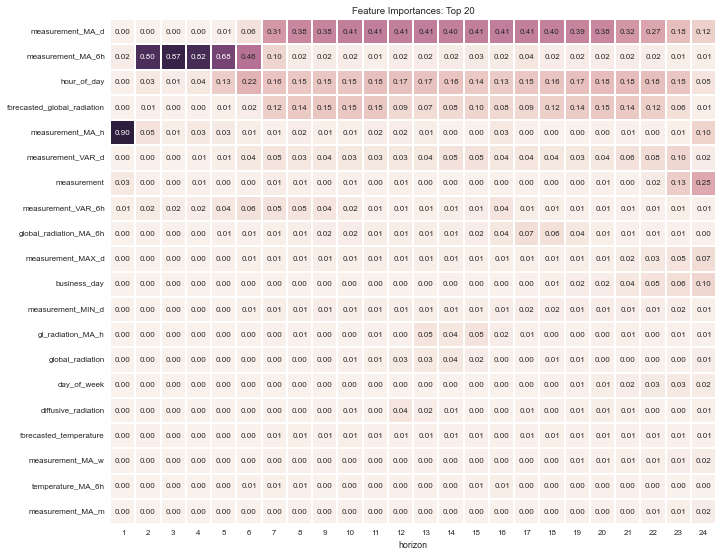

In [196]:
#top20_indices = np.argsort(list(feature_importances_all.mean(axis=1)))[::-1][0:20]

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(top20, square=True, annot=True, annot_kws={"size": 8}, fmt=".2f", cbar=False)
plt.title("Feature Importances: Top 20")
plt.tight_layout()
plt.savefig("./figures/featureImportanceTop20.pdf")
plt.savefig("./figures/featureImportanceTop20.png", dpi=300)

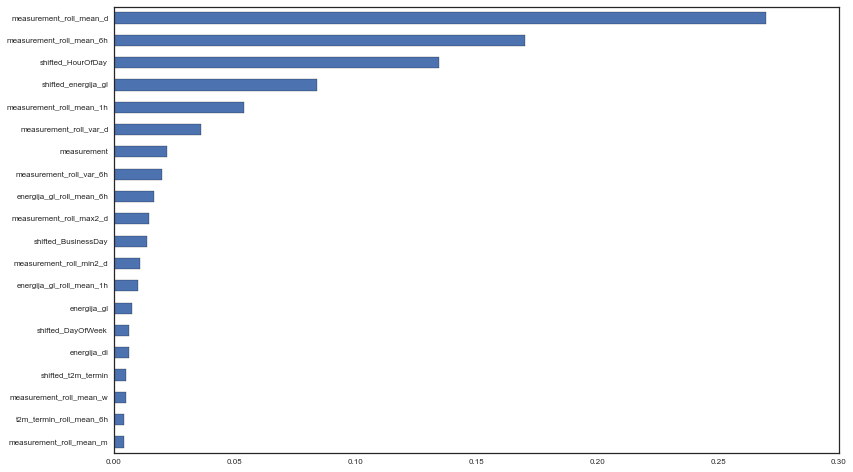

In [146]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

ax = feature_importances_all_mean[:20][::-1].plot(kind='barh', figsize=(13,8))
sns.set_style("whitegrid")
    
plt.savefig("./figures/listOfTop20Features.png", dpi=300)

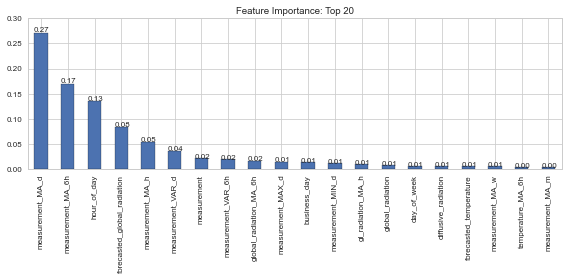

In [184]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

#ax = feature_importances_all_mean[:20].plot(kind='bar', figsize=(12,5), title="Feature Importance: Top 20")
ax = top20.mean(axis=1).plot(kind='bar', figsize=(8,3), title="Feature Importance: Top 20")
sns.set_style("whitegrid")
for p in ax.patches:
    ax.annotate(str("%.2f" % p.get_height()), (p.get_x() , p.get_height() * 1.02), fontsize=8)
plt.tight_layout()
plt.savefig("./figures/listOfTop20Features.png", dpi=300)